# ANOVA Feature Selection

In [5]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_selection import f_classif

PROJECT_ROOT = Path("..").resolve()
OUT_DIR = PROJECT_ROOT / "outputs"
FEAT_CSV = OUT_DIR / "extracted_features.csv"

RANK_DIR = OUT_DIR / "rankings"
DATASET_DIR = OUT_DIR / "datasets"
RANK_DIR.mkdir(parents=True, exist_ok=True)
DATASET_DIR.mkdir(parents=True, exist_ok=True)

print(f"Loaded features from: {FEAT_CSV}")

Loaded features from: /home/hp/Downloads/addressing_agricultural_challenges/outputs/extracted_features.csv


In [6]:
feat_df = pd.read_csv(FEAT_CSV)
print(f"Loaded {len(feat_df)} images with {len(feat_df.columns)} columns")
feat_df.head()

Loaded 724 images with 22 columns


,CNT,CRL,SKEN,KTS,VAR,STD,ENT,EG,MN,HGN,...,IDM,Output,ClassName,orig_path,prep_path,chosen,f1_pick,p_final,r_final,f1_final
0,5.723888,0.987658,0.563714,3.367663,1334.582135,36.531933,6.670479,0.104164,51.389039,0.647028,...,0.647028,1,Anthracnose,E:\Kuliah\Pengenalan Pola\addressing_agricultu...,E:\Kuliah\Pengenalan Pola\addressing_agricultu...,[1],0.637451,0.680558,0.653265,0.666633
1,20.733715,0.950787,0.597947,3.122097,3613.386267,60.111449,7.421945,0.062476,97.628786,0.387375,...,0.387375,1,Anthracnose,E:\Kuliah\Pengenalan Pola\addressing_agricultu...,E:\Kuliah\Pengenalan Pola\addressing_agricultu...,"[1, 2]",0.547897,0.375440,1.000000,0.545920
2,8.463067,0.984609,0.287901,1.867356,4393.235580,66.281487,7.779396,0.066144,135.332150,0.562726,...,0.562726,1,Anthracnose,E:\Kuliah\Pengenalan Pola\addressing_agricultu...,E:\Kuliah\Pengenalan Pola\addressing_agricultu...,"[0, 2]",0.512146,0.347382,1.000000,0.515640
3,6.144520,0.982131,0.480171,2.136493,2108.565763,45.919122,7.306347,0.073773,123.626680,0.555171,...,0.555171,1,Anthracnose,E:\Kuliah\Pengenalan Pola\addressing_agricultu...,E:\Kuliah\Pengenalan Pola\addressing_agricultu...,"[0, 2]",0.565698,0.443959,0.940006,0.603085
4,6.912518,0.984983,0.344395,4.448925,807.453287,28.415723,6.518133,0.111556,49.570963,0.640639,...,0.640639,1,Anthracnose,E:\Kuliah\Pengenalan Pola\addressing_agricultu...,E:\Kuliah\Pengenalan Pola\addressing_agricultu...,[0],0.746585,0.654970,0.919766,0.765105


In [7]:
DROP_COLS = {"Output", "ClassName", "orig_path", "prep_path", "Path", "chosen", 
             "f1_pick", "p_final", "r_final", "f1_final", "precision", "recall", "f1"}

feature_cols = [c for c in feat_df.columns if c not in DROP_COLS 
                and pd.api.types.is_numeric_dtype(feat_df[c])]

print(f"Features selected: {feature_cols}")
print(f"Total features: {len(feature_cols)}")

X = feat_df[feature_cols].to_numpy()
y = feat_df["Output"].astype(int).to_numpy()

Features selected: ['CNT', 'CRL', 'SKEN', 'KTS', 'VAR', 'STD', 'ENT', 'EG', 'MN', 'HGN', 'RMS', 'SM', 'IDM']
Total features: 13


In [8]:
F, p = f_classif(X, y)

anova_rank = (
    pd.DataFrame({"feature": feature_cols, "score": F, "p_value": p})
    .sort_values("score", ascending=False)
    .reset_index(drop=True)
)

anova_rank_path = RANK_DIR / "anova_rank.csv"
anova_rank.to_csv(anova_rank_path, index=False)

print(f"✓ ANOVA ranking saved to {anova_rank_path}")
anova_rank.head(15)

✓ ANOVA ranking saved to /home/hp/Downloads/addressing_agricultural_challenges/outputs/rankings/anova_rank.csv


,feature,score,p_value
0,VAR,229.460269,3.253839e-45
1,STD,208.106704,1.222318e-41
2,ENT,150.161723,1.690851e-31
3,CRL,146.138087,9.075840e-31
4,CNT,99.569132,4.698271e-22
5,HGN,67.529145,9.600343e-16
6,IDM,67.529145,9.600343e-16
7,KTS,59.542633,3.986613e-14
8,SM,59.110470,4.883530e-14
9,RMS,10.274760,1.408005e-03


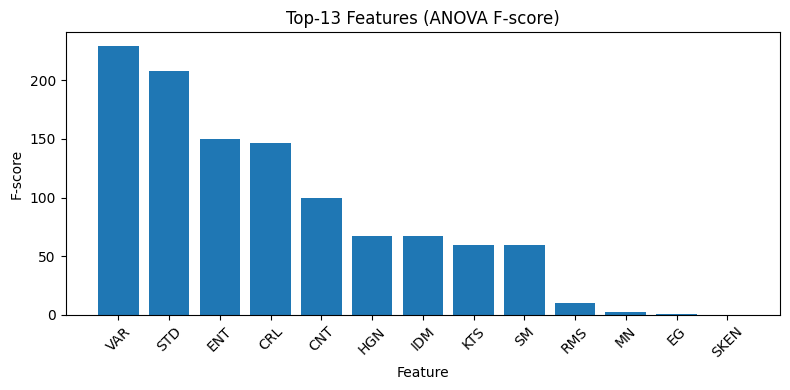

✓ Plot saved to /home/hp/Downloads/addressing_agricultural_challenges/outputs/rankings/anova_rank_top.png


In [9]:
TOP_N = min(13, len(anova_rank))

fig, ax = plt.subplots(figsize=(8, 4))
ax.bar(anova_rank["feature"].head(TOP_N), anova_rank["score"].head(TOP_N))
ax.set_title(f"Top-{TOP_N} Features (ANOVA F-score)")
ax.set_xlabel("Feature")
ax.set_ylabel("F-score")
ax.tick_params(axis="x", rotation=45)
plt.tight_layout()
plt.show()

plot_path = RANK_DIR / "anova_rank_top.png"
fig.savefig(plot_path, bbox_inches="tight", dpi=150)
print(f"✓ Plot saved to {plot_path}")

In [10]:
def save_topk_dataset(rank_df: pd.DataFrame, k: int, suffix: str = "A"):
    top_feats = rank_df["feature"].head(k).tolist()
    metadata_cols = [c for c in ["ClassName", "orig_path", "prep_path", "Path"] 
                     if c in feat_df.columns]
    keep_cols = top_feats + ["Output"] + metadata_cols
    
    out_df = feat_df[keep_cols].copy()
    out_path = DATASET_DIR / f"data{k}{suffix}.csv"
    out_df.to_csv(out_path, index=False)
    
    print(f"✓ Saved {out_path} | Shape: {out_df.shape}")
    return out_path, top_feats

for k in [5, 7, 9, 10]:
    save_topk_dataset(anova_rank, k, suffix="A")

✓ Saved /home/hp/Downloads/addressing_agricultural_challenges/outputs/datasets/data5A.csv | Shape: (724, 9)
✓ Saved /home/hp/Downloads/addressing_agricultural_challenges/outputs/datasets/data7A.csv | Shape: (724, 11)
✓ Saved /home/hp/Downloads/addressing_agricultural_challenges/outputs/datasets/data9A.csv | Shape: (724, 13)
✓ Saved /home/hp/Downloads/addressing_agricultural_challenges/outputs/datasets/data10A.csv | Shape: (724, 14)


In [11]:
print("\nDataset Summary:")
for k in [5, 7, 9, 10]:
    p = DATASET_DIR / f"data{k}A.csv"
    dfk = pd.read_csv(p)
    print(f"  {p.name}: {dfk.shape}")

dfk = pd.read_csv(DATASET_DIR / "data10A.csv")
print(f"\nPreview (data10A.csv):")
dfk.head()


Dataset Summary:
  data5A.csv: (724, 9)
  data7A.csv: (724, 11)
  data9A.csv: (724, 13)
  data10A.csv: (724, 14)

Preview (data10A.csv):


,VAR,STD,ENT,CRL,CNT,HGN,IDM,KTS,SM,RMS,Output,ClassName,orig_path,prep_path
0,1334.582135,36.531933,6.670479,0.987658,5.723888,0.647028,0.647028,3.367663,0.999251,63.050896,1,Anthracnose,E:\Kuliah\Pengenalan Pola\addressing_agricultu...,E:\Kuliah\Pengenalan Pola\addressing_agricultu...
1,3613.386267,60.111449,7.421945,0.950787,20.733715,0.387375,0.387375,3.122097,0.999723,114.650626,1,Anthracnose,E:\Kuliah\Pengenalan Pola\addressing_agricultu...,E:\Kuliah\Pengenalan Pola\addressing_agricultu...
2,4393.235580,66.281487,7.779396,0.984609,8.463067,0.562726,0.562726,1.867356,0.999772,150.691826,1,Anthracnose,E:\Kuliah\Pengenalan Pola\addressing_agricultu...,E:\Kuliah\Pengenalan Pola\addressing_agricultu...
3,2108.565763,45.919122,7.306347,0.982131,6.144520,0.555171,0.555171,2.136493,0.999526,131.879194,1,Anthracnose,E:\Kuliah\Pengenalan Pola\addressing_agricultu...,E:\Kuliah\Pengenalan Pola\addressing_agricultu...
4,807.453287,28.415723,6.518133,0.984983,6.912518,0.640639,0.640639,4.448925,0.998763,57.137848,1,Anthracnose,E:\Kuliah\Pengenalan Pola\addressing_agricultu...,E:\Kuliah\Pengenalan Pola\addressing_agricultu...
